In [1]:
from src.pyha_visualization import local_line_graph
from src.TweetyNetAudio import load_wav
import pandas as pd
import numpy as np
import tabulate
from tabulate import tabulate
import os
import sys

In [2]:
def kaliedoscope_format(df, filename):
    filtered_df = df[df["file"] == filename]
    print(filtered_df["pred"])
    print("HERE")
    print(len(filtered_df))
    if filtered_df.empty == True:
        print("THERE")
        print(f"file: {filename} was not in test set")
        return filtered_df
    sorted_filtered_df = filtered_df.sort_values("overall frame number")
    #print(sum(sorted_filtered_df["pred"]))
    time_bin_seconds = sorted_filtered_df.iloc[1]["temporal_frame_start_times"]
    #print(time_bin_seconds)
    zero_sorted_filtered_df = sorted_filtered_df[sorted_filtered_df["pred"] == 0]
    offset = zero_sorted_filtered_df["temporal_frame_start_times"]
    duration = zero_sorted_filtered_df["temporal_frame_start_times"].diff().shift(-1)
    intermediary_df = pd.DataFrame({"OFFSET": offset, "DURATION": duration})
    print(intermediary_df)

    kaliedoscope_df = []
    if offset.iloc[0] != 0:
        kaliedoscope_df.append(pd.DataFrame({"OFFSET": [0], "DURATION": [offset.iloc[0]]}))
    kaliedoscope_df.append(intermediary_df[intermediary_df["DURATION"] >= 2*time_bin_seconds])


    if offset.iloc[-1] < sorted_filtered_df.iloc[-1]["temporal_frame_start_times"]:
        kaliedoscope_df.append(pd.DataFrame({"OFFSET": [offset.iloc[-1]], "DURATION": [sorted_filtered_df.iloc[-1]["temporal_frame_start_times"] + 
                                sorted_filtered_df.iloc[1]["temporal_frame_start_times"]]}))


    kaliedoscope_df = pd.concat(kaliedoscope_df)
    kaliedoscope_df = kaliedoscope_df.reset_index(drop=True)
    # print(kaliedoscope_df)
    return kaliedoscope_df#.to_csv(filename+'.csv')
    

In [3]:
def get_wav(filename, dataset_type):
    if dataset_type =="NIPS":
        Wav_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train", filename)
        SR, SIGNAL = load_wav(Wav_path)
        return SR, SIGNAL, Wav_path
    elif dataset_type == "PYRE":
        Wav_path = os.path.join("data","PYRE","Mixed_Bird-20220126T212121Z-003", "Mixed_Bird", filename)
        SR, SIGNAL = load_wav(Wav_path)
        return SR, SIGNAL, Wav_path
    else:
        print(f"Dataset: {dataset_type} does not exist")
        return None
    

def get_premade_annotations(filename, csv, dataset_type):
    if dataset_type =="NIPS":
        premade_annotations_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b", csv)
        premade_annotations_df = pd.read_csv(premade_annotations_path, names=["OFFSET", "DURATION", "TAG"])
        return premade_annotations_df
    elif dataset_type == "PYRE":
        premade_annotations_path = os.path.join("data", "PYRE", csv)
        premade_annotations_df = pd.read_csv(premade_annotations_path)
        premade_annotations_df = premade_annotations_df[premade_annotations_df["IN FILE"] == filename]
        if len(premade_annotations_df) == 0:
            print(f"No premade annotations for file: {filename}")
        premade_annotations_df = premade_annotations_df[["OFFSET", "DURATION", "MANUAL ID"]]
        return premade_annotations_df
    else:
        print(f"Dataset: {dataset_type} does not exist")
        return None


In [4]:
def create_visualization(filename, csv, dataset_type):
    SR, SIGNAL, Wav_path = get_wav(filename, dataset_type)
    automated_annotations_path = os.path.join("data", "out", "Evaluation_on_data.csv")
    if automated_annotations_path == "":
        automated_df = pd.DataFrame()
    else:
        automated_df = pd.read_csv(automated_annotations_path)
        automated_df = kaliedoscope_format(automated_df, filename)
    print(automated_df)
    premade_annotations_df = get_premade_annotations(filename, csv, dataset_type)
    premade_annotations_label = "Bird"
    print(premade_annotations_df)
    
    # change local scores to what tweetynet returns.
    log_scale = True
    save_fig = False
    normalize_local_scores = False
    local_line_graph([0] * 216,
        Wav_path,
        SR,
        samples=SIGNAL,
        automated_df= automated_df,
        premade_annotations_df=premade_annotations_df,
        premade_annotations_label=premade_annotations_label,
        log_scale=log_scale,
        save_fig=save_fig,
        normalize_local_scores=normalize_local_scores)

Attila-cinnamomeus-206109.wav
1634    0
1635    0
1636    0
1637    0
1638    0
       ..
3951    0
3952    0
3953    0
3954    0
3955    0
Name: pred, Length: 2322, dtype: int64
HERE
2322
         OFFSET  DURATION
1634   0.000000   0.02322
1635   0.023220   0.02322
1636   0.046440   0.02322
1637   0.069660   0.02322
1638   0.092880   0.02322
...         ...       ...
3951  53.880816   0.02322
3952  53.904036   0.02322
3953  53.927256   0.02322
3954  53.950476   0.02322
3955  53.973696       NaN

[1612 rows x 2 columns]
       OFFSET  DURATION
0    1.973696  1.210522
1    5.277098  1.303401
2    8.580499  1.114558
3   11.741497  1.256961
4   14.905578  1.094422
5   18.348299  1.207438
6   21.532517  1.373061
7   24.696599  1.303401
8   27.973696  1.210522
9   31.973696  1.187302
10  35.973696  1.164082
11  39.277098  1.187302
12  43.973696  1.094422
13  47.253878  1.140862
       OFFSET  DURATION                           MANUAL ID
2306   1.2810    1.9498  Attila cinnamomeus Cinnamon A

c:\Users\lianl\Repositories\TweetyNet_CUDA_GPU_Adaptation\src\pyha_visualization.py:81: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')


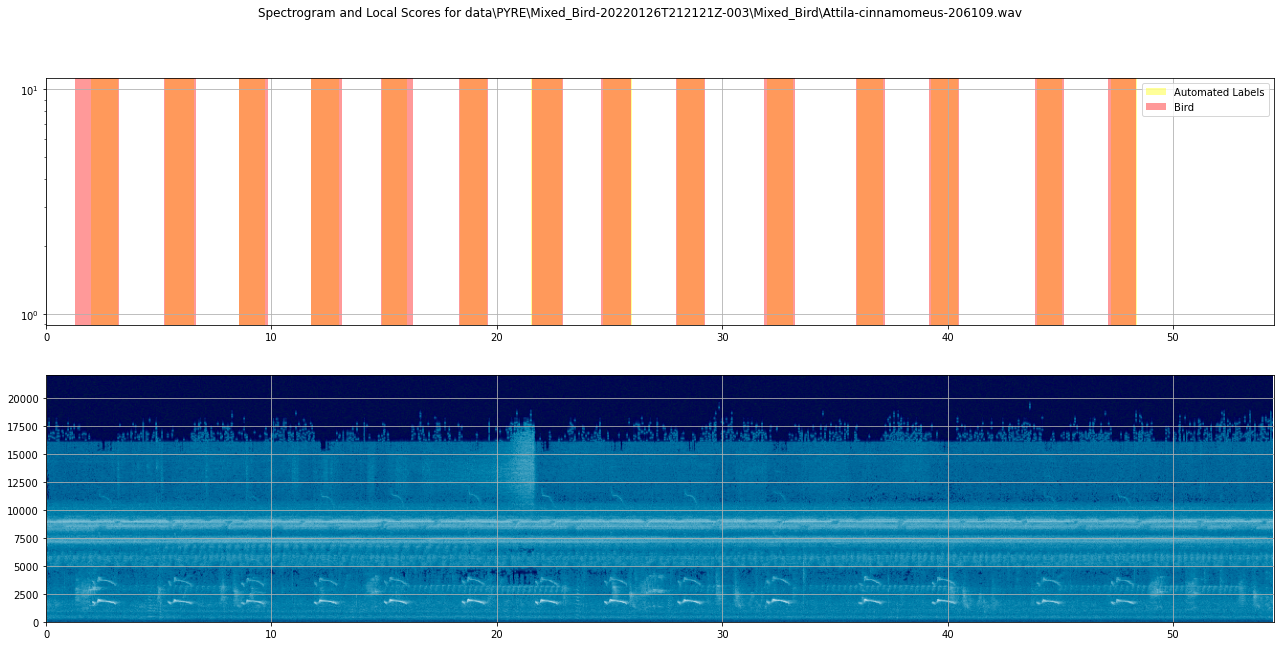

In [5]:
#PYRE example
folder = os.path.join("data","PYRE", "Mixed_Bird-20220126T212121Z-003", "Mixed_Bird")
csv_file = "for_data_science_newline_fixed.csv"
files = os.listdir(folder)


folder = os.path.join("data","out","separate_evaluations")
# csv_file = "for_data_science_newline_fixed.csv"
files = os.listdir(folder)
# print(files)
print('classificationfile_Attila-cinnamomeus-206109.wav.csv'[19:-4])


pyre_notes = pd.read_csv(os.path.join("data","PYRE",'for_data_science_newline_fixed.csv'))
valid_filenames = pyre_notes["IN FILE"].drop_duplicates().values.tolist() 
# print(valid_filenames)
true_wavs = [i for i in files if i[19:-4] in valid_filenames]


# print(files)
# print(files[45])
create_visualization(true_wavs[0][19:-4], csv_file, "PYRE")

Series([], Name: pred, dtype: int64)
HERE
0
THERE
file: nips4b_birds_trainfile002.wav was not in test set
Empty DataFrame
Columns: [Unnamed: 0, uid, window file, file, overall frame number, frame number, window number, zero_pred, one_pred, pred, label, temporal_frame_start_times]
Index: []
     OFFSET  DURATION          TAG
0  0.007256  0.043537  Sylmel_song
1  0.066757  0.027574  Sylmel_song
2  0.110295  0.024671  Sylmel_song
3  0.148027  0.058050  Sylmel_song
4  0.255420  0.140771  Sylmel_song
5  0.442630  0.132063  Sylmel_song
6  0.592109  0.146576  Sylmel_song
7  0.878005  0.046440  Sylmel_song


c:\Users\lianl\Repositories\TweetyNet_CUDA_GPU_Adaptation\src\pyha_visualization.py:81: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')


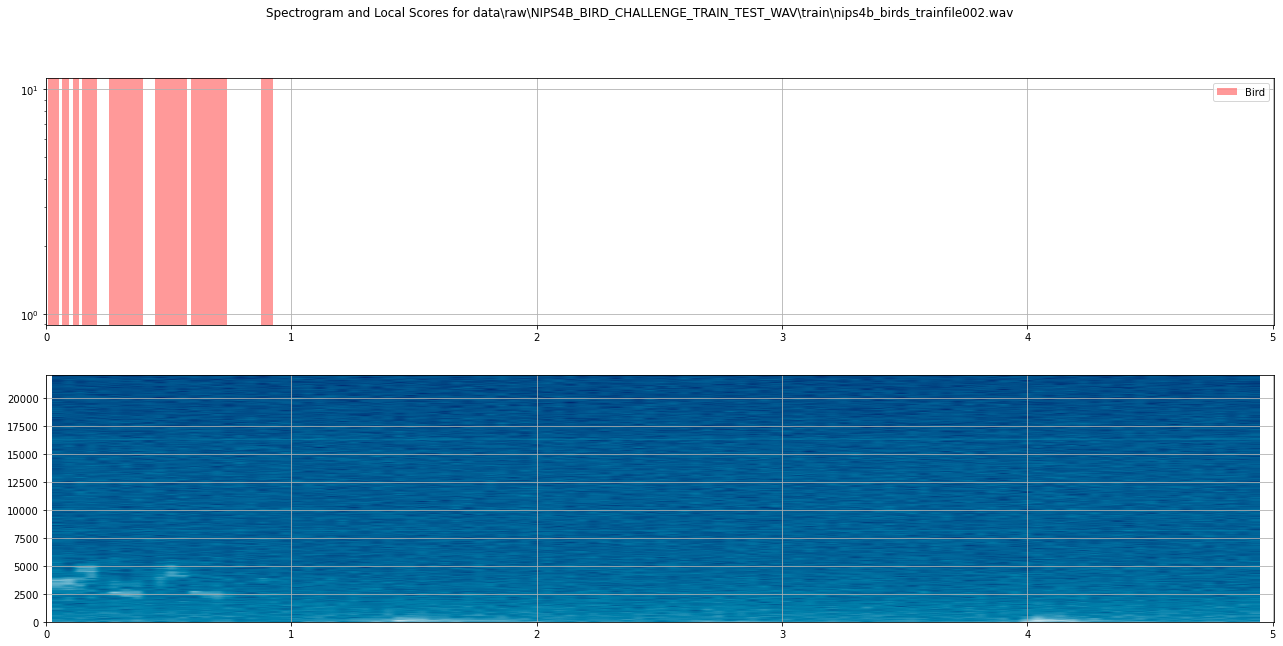

In [6]:
#nips example
folder = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train")
csv_folder = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b")
files = os.listdir(folder)
csvs = os.listdir(csv_folder)
#print(files[45])
create_visualization(files[1], csvs[1], "NIPS")

#use the evaluation_on_data.csv for this.

Series([], Name: pred, dtype: int64)
HERE
0
THERE
file: nips4b_birds_trainfile001.wav was not in test set
Empty DataFrame
Columns: [Unnamed: 0, uid, window file, file, overall frame number, frame number, window number, zero_pred, one_pred, pred, label, temporal_frame_start_times]
Index: []
     OFFSET  DURATION          TAG
0  0.095782  0.044989      Unknown
1  0.220590  0.243810  Butbut_call
2  0.592109  0.023220  Erirub_call
3  0.825760  0.026122  Erirub_call
4  1.584762  0.400544  Butbut_call
5  2.265397  0.020317  Erirub_call
6  2.356825  0.201723  Parate_call
7  2.478730  0.046440  Erirub_call
8  3.601995  0.236553      Unknown


c:\Users\lianl\Repositories\TweetyNet_CUDA_GPU_Adaptation\src\pyha_visualization.py:81: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[0].set_yscale('log')


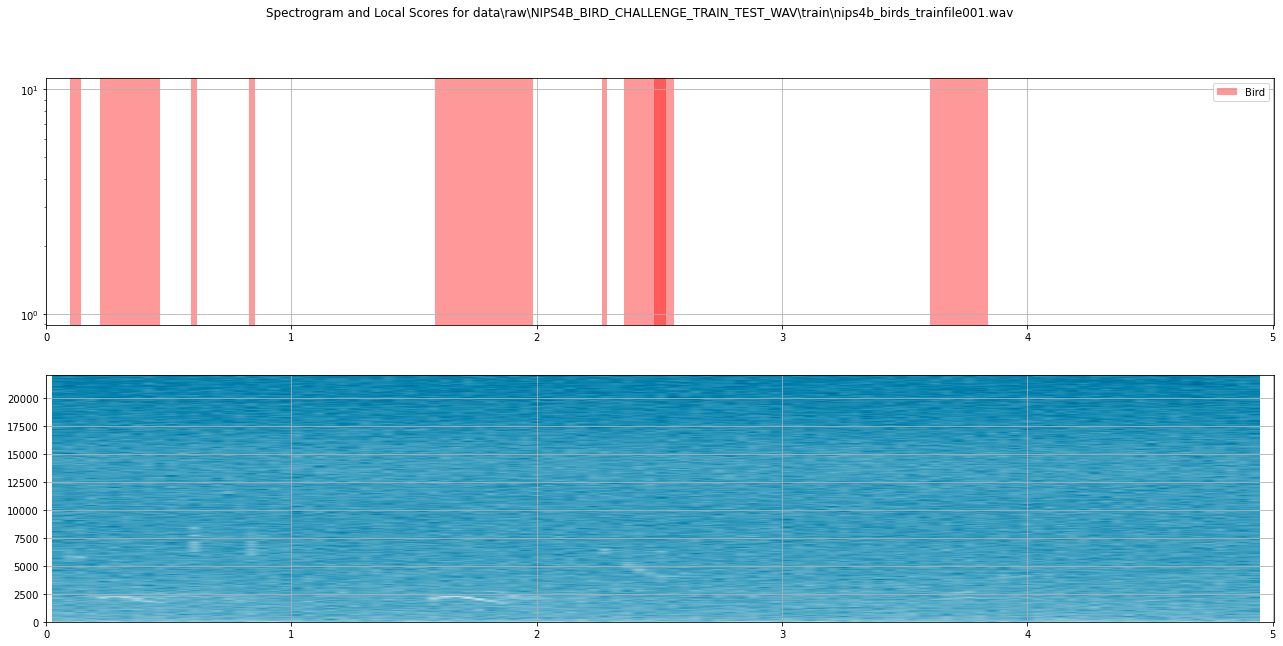

In [7]:
automated_annotations_path = os.path.join("data", "out", "Evaluation_on_data.csv")
premade_annotations_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","temporal_annotations_nips4b","annotation_train001.csv")
Wav_path = os.path.join("data","raw","NIPS4B_BIRD_CHALLENGE_TRAIN_TEST_WAV","train", "nips4b_birds_trainfile001.wav")
SR, SIGNAL = load_wav(Wav_path)
if automated_annotations_path == "":
    automated_df = pd.DataFrame()
else:
    automated_df = pd.read_csv(automated_annotations_path)
#print(automated_df.columns)
#add testing for kaliedoscope format
#automated_df.loc[0:50,"pred"] = 1
#automated_df.loc[100:150,"pred"] = 1
#automated_df.loc[175:198,"pred"] = 1
#automated_df.loc[200:215,"pred"] = 1
# Need to convert this df to kaliedoscope format
automated_df = kaliedoscope_format(automated_df, "nips4b_birds_trainfile001.wav")
print(automated_df)

premade_annotations_df = pd.read_csv(premade_annotations_path, names=["OFFSET", "DURATION", "TAG"])
premade_annotations_label = "Bird"
print(premade_annotations_df)
# change local scores to what tweetynet returns.
log_scale = True
save_fig = False
normalize_local_scores = False
local_line_graph([0] * 216,
    Wav_path,
    SR,
    samples=SIGNAL,
    automated_df= automated_df,
    premade_annotations_df=premade_annotations_df,
    premade_annotations_label=premade_annotations_label,
    log_scale=log_scale,
    save_fig=save_fig,
    normalize_local_scores=normalize_local_scores)